<a href="https://colab.research.google.com/github/erikstrand2/urban-data-informatics/blob/master/final-project/Stage_III_Travel_characteristics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stage III: Analysis of Unit Travel Characteristics

## Setup


In [ ]:
%%time 

# Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 
# Install Folium for Geographic data visualization
!pip install folium
# Install plotlyExpress
!pip install plotly_express
# Install mapclassify
!pip install mapclassify

# %load_ext google.colab.data_table

Reading package lists... Done
Building dependency tree       
Reading state information... Done
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
python3-gdal is already the newest version (2.2.3+dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-rtree is already the newest version (0.8.3+ds-1).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.
  Cloning git://github.com/geopandas/geopandas.git to /tmp/pip-req-build-k2vtnifz
  Running command git clone -q git://github.com/geopandas/geopandas.git /tmp/pip-req-build-k2vtnifz
  Created wheel for geopandas: filename=geopandas-0.8.0+72.ge506de5-py2.py3-none-any.whl size=973052 sha256=ab7b8c8009c17faa30fbeede33417f791280054263fc5f020090f26ab97471d4
  Stored in directory: /tmp/pip-ephem-wheel-cache-m189t5z2/wheels/91/24/71/376c9c67192694168352

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
import re
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import mapclassify
import matplotlib.cm as cm
import matplotlib.colors as colors
import statsmodels.formula.api as sm

## Taxi data and COVID-19 Data

This part aims to run correlations and regressions between COVID-19 data and trips change

In [ ]:
covid_bynta = gpd.read_file("drive/MyDrive/IUDI Final Project/data/covid_bynta")
covid_bynta["CASE_RATE"] = covid_bynta["Avg_grid_c"]

covid_bynta.head()

,OBJECTID,BoroCode,BoroName,CountyFIPS,NTACode,NTAName,Shape_Leng,Shape_Le_1,Shape_Area,Count_,Avg_pointi,Avg_grid_c,geometry,CASE_RATE
0,1,1,Manhattan,061,MN15,Clinton,34481.628773,34481.605660,1.836215e+07,43630,8.427355e+05,2296.806677,"POLYGON ((985958.652 220876.750, 985970.759 22...",2296.806677
1,2,1,Manhattan,061,MN25,Battery Park City-Lower Manhattan,43738.496041,43738.183813,1.901426e+07,38652,1.412032e+06,1775.924672,"MULTIPOLYGON (((984032.884 192223.748, 983984....",1775.924672
2,3,1,Manhattan,061,MN14,Lincoln Square,19869.908314,19869.681573,1.580552e+07,39251,7.283790e+05,1542.954969,"POLYGON ((991173.649 222552.152, 991046.810 22...",1542.954969
3,4,1,Manhattan,061,MN17,Midtown-Midtown South,27032.700221,27032.583487,3.019157e+07,73476,9.416262e+05,2239.991558,"POLYGON ((991725.244 217725.299, 992169.505 21...",2239.991558
4,5,1,Manhattan,061,MN40,Upper East Side-Carnegie Hill,23778.410362,23778.410362,2.006536e+07,50158,7.310517e+05,1784.171453,"POLYGON ((998281.392 225347.967, 998145.231 22...",1784.171453


In [ ]:
trips_19_cnts = pd.read_csv("drive/MyDrive/IUDI Final Project/data/trips_19_cnt.csv")
trips_20_cnts = pd.read_csv("drive/MyDrive/IUDI Final Project/data/trips_20_cnt.csv")
taxi_zones = gpd.read_file("drive/MyDrive/IUDI Final Project/data/taxi_zones")

trip_counts = trips_19_cnts[["PULocationID", "n"]].merge(trips_20_cnts[["PULocationID", "n"]], how = "outer", on = "PULocationID", suffixes = ("_19", "_20"))
trip_counts["change"] = trip_counts["n_20"] - trip_counts["n_19"]
trip_counts.head()

,PULocationID,n_19,n_20,change
0,1,3721,1762.0,-1959.0
1,2,64,16.0,-48.0
2,3,1031,751.0,-280.0
3,4,79608,27771.0,-51837.0
4,5,116,65.0,-51.0


In [ ]:
trips_byzone = taxi_zones.merge(trip_counts, left_on = "LocationID", right_on = "PULocationID")
trips_byzone["perc_change"] = trips_byzone["change"] / trips_byzone["n_19"]
covid_trips = gpd.sjoin(covid_bynta, trips_byzone, how = 'left')

print(len(covid_trips))
print(len(covid_bynta))
print(len(trips_byzone))
covid_trips.head()

246
29
259


,OBJECTID_left,BoroCode,BoroName,CountyFIPS,NTACode,NTAName,Shape_Leng_left,Shape_Le_1,Shape_Area_left,Count_,Avg_pointi,Avg_grid_c,geometry,CASE_RATE,index_right,OBJECTID_right,Shape_Leng_right,Shape_Area_right,zone,LocationID,borough,PULocationID,n_19,n_20,change,perc_change
0,1,1,Manhattan,061,MN15,Clinton,34481.628773,34481.60566,1.836215e+07,43630,842735.498694,2296.806677,"POLYGON ((985958.652 220876.750, 985970.759 22...",2296.806677,67,68,0.049337,0.000111,East Chelsea,68,Manhattan,68,1065069,393646.0,-671423.0,-0.630403
0,1,1,Manhattan,061,MN15,Clinton,34481.628773,34481.60566,1.836215e+07,43630,842735.498694,2296.806677,"POLYGON ((985958.652 220876.750, 985970.759 22...",2296.806677,241,246,0.069467,0.000281,West Chelsea/Hudson Yards,246,Manhattan,246,705036,276717.0,-428319.0,-0.607514
0,1,1,Manhattan,061,MN15,Clinton,34481.628773,34481.60566,1.836215e+07,43630,842735.498694,2296.806677,"POLYGON ((985958.652 220876.750, 985970.759 22...",2296.806677,99,100,0.024813,0.000037,Garment District,100,Manhattan,100,900006,325622.0,-574384.0,-0.638200
0,1,1,Manhattan,061,MN15,Clinton,34481.628773,34481.60566,1.836215e+07,43630,842735.498694,2296.806677,"POLYGON ((985958.652 220876.750, 985970.759 22...",2296.806677,225,230,0.031028,0.000056,Times Sq/Theatre District,230,Manhattan,230,1513660,564120.0,-949540.0,-0.627314
0,1,1,Manhattan,061,MN15,Clinton,34481.628773,34481.60566,1.836215e+07,43630,842735.498694,2296.806677,"POLYGON ((985958.652 220876.750, 985970.759 22...",2296.806677,47,48,0.043747,0.000094,Clinton East,48,Manhattan,48,1415245,512994.0,-902251.0,-0.637523


In [ ]:
covid_trips.columns.tolist()
covid_trips = covid_trips.groupby(['NTACode'])[['n_19', 'change']].sum()
covid_trips = covid_bynta.merge(covid_trips, on = 'NTACode')

covid_trips['perc_change'] = covid_trips['change'] / covid_trips['n_19']
# covid_trips.to_file('drive/MyDrive/IUDI Final Project/output/covid_trips')
covid_trips.shape

(29, 17)

In [ ]:
covid_trips[['CASE_RATE', 'perc_change']].corr()

,CASE_RATE,perc_change
CASE_RATE,1.000000,0.685562
perc_change,0.685562,1.000000


In [ ]:
ols = sm.ols(formula = "perc_change ~ CASE_RATE", data = covid_trips).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            perc_change   R-squared:                       0.470
Model:                            OLS   Adj. R-squared:                  0.450
Method:                 Least Squares   F-statistic:                     23.94
Date:                Thu, 17 Dec 2020   Prob (F-statistic):           4.06e-05
Time:                        22:01:40   Log-Likelihood:                 57.541
No. Observations:                  29   AIC:                            -111.1
Df Residuals:                      27   BIC:                            -108.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.7191      0.026    -27.769      0.000      -0.772      -0.666
CASE_RATE   5.342e-05   1.09e-05      4.893      0.000     3.1e-05    7.58e-05
==============================================================================
Omnibus:                       15.072   Durbin-Watson:                   1.358
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.459
Skew:                           1.316   Prob(JB):                     0.000162
Kurtosis:                       5.743   Cond. No.                     9.59e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.59e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

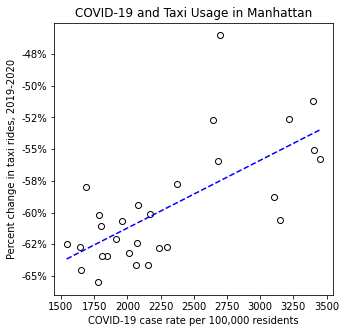

In [ ]:
plt.figure(figsize = (5,5))
plt.scatter(covid_trips['CASE_RATE'], covid_trips['perc_change'], color='white', edgecolor='k')
plt.xlabel("COVID-19 case rate per 100,000 residents")
plt.ylabel("Percent change in taxi rides, 2019-2020")
plt.title("COVID-19 and Taxi Usage in Manhattan")


x1 = covid_trips['CASE_RATE'].min()
x2 = covid_trips['CASE_RATE'].max()
y1 = ols.params[0] + (ols.params[1] * x1)
y2 = ols.params[0] + (ols.params[1] * x2)

plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.plot([x1, x2], [y1, y2], linestyle = '--', color = 'blue')

## Taxi data and ACS data

This part aims to run correlations and regressions of taxi data and ACS variables

In [ ]:
ACS = gpd.read_file("drive/MyDrive/IUDI Final Project/output/NTAPopulationGeo.shp")
ACS.head()

,Estimate!!,Estimate_1,Estimate_2,Estimate_3,Estimate_4,Estimate_5,Estimate_6,Estimate_7,Estimate_8,Estimate_9,Estimate10,Estimate11,Estimate12,Estimate13,Estimate14,Estimate15,Estimate16,Estimate17,Estimate18,Estimate19,Estimate20,Estimate21,Estimate22,Estimate23,Estimate24,Estimate25,Estimate26,Estimate27,2010 Censu,2010 NYC B,2010 Cen_1,PUMA,OBJECTID,BoroCode,BoroName,CountyFIPS,NTACode,NTAName,Shape__Are,Shape__Len,geometry
0,52922,3258.786,7657.150,4906.304,17037.718,7191.019,5805.146,4314.578,2735.144,262.6,24959.899,27962.101,1.731266e+06,7621.772947,5496.189399,6710.529916,5039.484239,3098.080014,43746,8224.408,4903.912,6289.176,4932.279,3979.110,2911.683,1626.413,4809.014,192567,427.0,7.0,209700.0,26607.0,79,1,Manhattan,061,MN01,Marble Hill-Inwood,1.773272e+07,31844.333429,"MULTIPOLYGON (((1005959.774 251373.191, 100593..."
1,86117,6413.088,11833.941,8279.028,29427.145,11696.000,9328.778,5057.468,4084.180,561.8,38453.680,47663.320,2.029293e+06,9327.091542,11394.954841,11474.914199,8764.749919,6697.850967,70401,12627.303,7567.958,8363.848,5915.838,7057.522,6402.155,2012.410,9448.639,490461,976.0,16.0,362306.0,60848.0,74,1,Manhattan,061,MN03,Central Harlem North-Polo Grounds,2.540349e+07,27983.841731,"POLYGON ((1002387.622 243857.529, 1002357.734 ..."
2,52700,2692.562,6715.124,5117.492,19520.898,7696.995,5382.058,2697.475,2867.127,241.0,26863.089,25836.911,1.473620e+06,6451.328183,5316.606556,4577.948854,5516.373001,3991.146548,44895,7486.298,4275.088,7118.635,4927.450,5151.462,3656.003,1387.938,4994.420,187162,427.0,7.0,161701.0,26614.0,101,1,Manhattan,061,MN04,Hamilton Heights,1.609614e+07,17411.381931,"POLYGON ((1000758.022 241844.088, 1000814.808 ..."
3,23673,1508.398,2745.913,3054.987,8123.563,3075.819,2455.242,1434.192,1282.923,132.7,10979.421,12693.579,5.519668e+05,3134.327191,3362.322675,2604.600556,2134.125067,1464.383883,20127,4191.589,2332.480,2899.364,2210.208,1769.312,1425.839,554.994,1434.440,80189,305.0,5.0,109509.0,19010.0,143,1,Manhattan,061,MN06,Manhattanville,1.064708e+07,17040.685896,"POLYGON ((999173.862 238493.121, 999084.171 23..."
4,53094,1498.935,4361.448,13561.991,16017.062,5080.501,4759.339,4194.406,3607.134,307.2,23632.447,29461.553,1.419966e+06,2746.880703,3587.588883,3591.723849,7501.811440,12036.893845,48135,7760.386,2951.562,4365.270,3558.266,3071.511,2624.541,1203.172,9174.187,324817,610.0,10.0,202004.0,38020.0,144,1,Manhattan,061,MN09,Morningside Heights,2.015591e+07,20746.031807,"POLYGON ((997508.803 234914.241, 997373.294 23..."


In [ ]:
acs_trips = gpd.sjoin(ACS, trips_byzone, how = 'left')
print(len(acs_trips))
print(len(ACS))
print(len(trips_byzone))
acs_trips.head()

198
29
259


,Estimate!!,Estimate_1,Estimate_2,Estimate_3,Estimate_4,Estimate_5,Estimate_6,Estimate_7,Estimate_8,Estimate_9,Estimate10,Estimate11,Estimate12,Estimate13,Estimate14,Estimate15,Estimate16,Estimate17,Estimate18,Estimate19,Estimate20,Estimate21,Estimate22,Estimate23,Estimate24,Estimate25,Estimate26,Estimate27,2010 Censu,2010 NYC B,2010 Cen_1,PUMA,OBJECTID_left,BoroCode,BoroName,CountyFIPS,NTACode,NTAName,Shape__Are,Shape__Len,geometry,index_right,OBJECTID_right,Shape_Leng,Shape_Area,zone,LocationID,borough,PULocationID,n_19,n_20,change,perc_change
0,52922,3258.786,7657.15,4906.304,17037.718,7191.019,5805.146,4314.578,2735.144,262.6,24959.899,27962.101,1.731266e+06,7621.772947,5496.189399,6710.529916,5039.484239,3098.080014,43746,8224.408,4903.912,6289.176,4932.279,3979.11,2911.683,1626.413,4809.014,192567,427.0,7.0,209700.0,26607.0,79,1,Manhattan,061,MN01,Marble Hill-Inwood,1.773272e+07,31844.333429,"MULTIPOLYGON (((1005959.774 251373.191, 100593...",122,127,0.060019,0.000163,Inwood,127,Manhattan,127,4511,2204.0,-2307.0,-0.511417
0,52922,3258.786,7657.15,4906.304,17037.718,7191.019,5805.146,4314.578,2735.144,262.6,24959.899,27962.101,1.731266e+06,7621.772947,5496.189399,6710.529916,5039.484239,3098.080014,43746,8224.408,4903.912,6289.176,4932.279,3979.11,2911.683,1626.413,4809.014,192567,427.0,7.0,209700.0,26607.0,79,1,Manhattan,061,MN01,Marble Hill-Inwood,1.773272e+07,31844.333429,"MULTIPOLYGON (((1005959.774 251373.191, 100593...",123,128,0.070209,0.000207,Inwood Hill Park,128,Manhattan,128,426,194.0,-232.0,-0.544601
0,52922,3258.786,7657.15,4906.304,17037.718,7191.019,5805.146,4314.578,2735.144,262.6,24959.899,27962.101,1.731266e+06,7621.772947,5496.189399,6710.529916,5039.484239,3098.080014,43746,8224.408,4903.912,6289.176,4932.279,3979.11,2911.683,1626.413,4809.014,192567,427.0,7.0,209700.0,26607.0,79,1,Manhattan,061,MN01,Marble Hill-Inwood,1.773272e+07,31844.333429,"MULTIPOLYGON (((1005959.774 251373.191, 100593...",148,153,0.024737,0.000032,Marble Hill,153,Manhattan,153,979,396.0,-583.0,-0.595506
0,52922,3258.786,7657.15,4906.304,17037.718,7191.019,5805.146,4314.578,2735.144,262.6,24959.899,27962.101,1.731266e+06,7621.772947,5496.189399,6710.529916,5039.484239,3098.080014,43746,8224.408,4903.912,6289.176,4932.279,3979.11,2911.683,1626.413,4809.014,192567,427.0,7.0,209700.0,26607.0,79,1,Manhattan,061,MN01,Marble Hill-Inwood,1.773272e+07,31844.333429,"MULTIPOLYGON (((1005959.774 251373.191, 100593...",215,220,0.106016,0.000313,Spuyten Duyvil/Kingsbridge,220,Bronx,220,2222,1323.0,-899.0,-0.404590
0,52922,3258.786,7657.15,4906.304,17037.718,7191.019,5805.146,4314.578,2735.144,262.6,24959.899,27962.101,1.731266e+06,7621.772947,5496.189399,6710.529916,5039.484239,3098.080014,43746,8224.408,4903.912,6289.176,4932.279,3979.11,2911.683,1626.413,4809.014,192567,427.0,7.0,209700.0,26607.0,79,1,Manhattan,061,MN01,Marble Hill-Inwood,1.773272e+07,31844.333429,"MULTIPOLYGON (((1005959.774 251373.191, 100593...",115,120,0.083261,0.000093,Highbridge Park,120,Manhattan,120,274,125.0,-149.0,-0.543796


In [ ]:
acs_trips = acs_trips.groupby(['NTACode'])[['n_19','change']].sum()
acs_trips = ACS.merge(acs_trips, on = 'NTACode')
acs_trips['perc_change'] = acs_trips['change'] / acs_trips['n_19']
acs_trips['Estimate__'] = acs_trips['Estimate!!']


acs_trips.head()

,Estimate!!,Estimate_1,Estimate_2,Estimate_3,Estimate_4,Estimate_5,Estimate_6,Estimate_7,Estimate_8,Estimate_9,Estimate10,Estimate11,Estimate12,Estimate13,Estimate14,Estimate15,Estimate16,Estimate17,Estimate18,Estimate19,Estimate20,Estimate21,Estimate22,Estimate23,Estimate24,Estimate25,Estimate26,Estimate27,2010 Censu,2010 NYC B,2010 Cen_1,PUMA,OBJECTID,BoroCode,BoroName,CountyFIPS,NTACode,NTAName,Shape__Are,Shape__Len,geometry,n_19,change,perc_change,Estimate__
0,52922,3258.786,7657.150,4906.304,17037.718,7191.019,5805.146,4314.578,2735.144,262.6,24959.899,27962.101,1.731266e+06,7621.772947,5496.189399,6710.529916,5039.484239,3098.080014,43746,8224.408,4903.912,6289.176,4932.279,3979.110,2911.683,1626.413,4809.014,192567,427.0,7.0,209700.0,26607.0,79,1,Manhattan,061,MN01,Marble Hill-Inwood,1.773272e+07,31844.333429,"MULTIPOLYGON (((1005959.774 251373.191, 100593...",8412,-4170.0,-0.495720,52922
1,86117,6413.088,11833.941,8279.028,29427.145,11696.000,9328.778,5057.468,4084.180,561.8,38453.680,47663.320,2.029293e+06,9327.091542,11394.954841,11474.914199,8764.749919,6697.850967,70401,12627.303,7567.958,8363.848,5915.838,7057.522,6402.155,2012.410,9448.639,490461,976.0,16.0,362306.0,60848.0,74,1,Manhattan,061,MN03,Central Harlem North-Polo Grounds,2.540349e+07,27983.841731,"POLYGON ((1002387.622 243857.529, 1002357.734 ...",351064,-182547.0,-0.519982,86117
2,52700,2692.562,6715.124,5117.492,19520.898,7696.995,5382.058,2697.475,2867.127,241.0,26863.089,25836.911,1.473620e+06,6451.328183,5316.606556,4577.948854,5516.373001,3991.146548,44895,7486.298,4275.088,7118.635,4927.450,5151.462,3656.003,1387.938,4994.420,187162,427.0,7.0,161701.0,26614.0,101,1,Manhattan,061,MN04,Hamilton Heights,1.609614e+07,17411.381931,"POLYGON ((1000758.022 241844.088, 1000814.808 ...",180890,-93134.0,-0.514865,52700
3,23673,1508.398,2745.913,3054.987,8123.563,3075.819,2455.242,1434.192,1282.923,132.7,10979.421,12693.579,5.519668e+05,3134.327191,3362.322675,2604.600556,2134.125067,1464.383883,20127,4191.589,2332.480,2899.364,2210.208,1769.312,1425.839,554.994,1434.440,80189,305.0,5.0,109509.0,19010.0,143,1,Manhattan,061,MN06,Manhattanville,1.064708e+07,17040.685896,"POLYGON ((999173.862 238493.121, 999084.171 23...",98156,-54242.0,-0.552610,23673
4,53094,1498.935,4361.448,13561.991,16017.062,5080.501,4759.339,4194.406,3607.134,307.2,23632.447,29461.553,1.419966e+06,2746.880703,3587.588883,3591.723849,7501.811440,12036.893845,48135,7760.386,2951.562,4365.270,3558.266,3071.511,2624.541,1203.172,9174.187,324817,610.0,10.0,202004.0,38020.0,144,1,Manhattan,061,MN09,Morningside Heights,2.015591e+07,20746.031807,"POLYGON ((997508.803 234914.241, 997373.294 23...",1274780,-778786.0,-0.610918,53094


In [ ]:
acs_trips[['Estimate__', 'perc_change']].corr()

,Estimate__,perc_change
Estimate__,1.000000,0.213206
perc_change,0.213206,1.000000


In [ ]:
ols = sm.ols(formula = "perc_change ~ Estimate__", data = acs_trips).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            perc_change   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     1.286
Date:                Thu, 17 Dec 2020   Prob (F-statistic):              0.267
Time:                        22:01:42   Log-Likelihood:                 50.686
No. Observations:                  29   AIC:                            -97.37
Df Residuals:                      27   BIC:                            -94.64
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.6167      0.020    -30.757      0.000      -0.658      -0.576
Estimate__  3.694e-07   3.26e-07      1.134      0.267   -2.99e-07    1.04e-06
==============================================================================
Omnibus:                        4.412   Durbin-Watson:                   0.431
Prob(Omnibus):                  0.110   Jarque-Bera (JB):                3.770
Skew:                           0.878   Prob(JB):                        0.152
Kurtosis:                       2.806   Cond. No.                     1.52e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.52e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

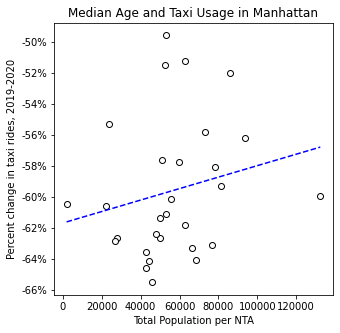

In [ ]:
plt.figure(figsize = (5,5))
plt.scatter(acs_trips['Estimate__'], acs_trips['perc_change'], color='white', edgecolor='k')
plt.xlabel("Total Population per NTA")
plt.ylabel("Percent change in taxi rides, 2019-2020")
plt.title("Median Age and Taxi Usage in Manhattan")

x1 = acs_trips['Estimate__'].min()
x2 = acs_trips['Estimate__'].max()
y1 = ols.params[0] + (ols.params[1] * x1)
y2 = ols.params[0] + (ols.params[1] * x2)

plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.plot([x1, x2], [y1, y2], linestyle = '--', color = 'blue')

In [ ]:
acs_trips[['Estimate_9', 'perc_change']].corr()

,Estimate_9,perc_change
Estimate_9,1.000000,-0.070857
perc_change,-0.070857,1.000000


In [ ]:
ols = sm.ols(formula = "perc_change ~ Estimate_9", data = acs_trips).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            perc_change   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.032
Method:                 Least Squares   F-statistic:                    0.1362
Date:                Thu, 17 Dec 2020   Prob (F-statistic):              0.715
Time:                        22:01:46   Log-Likelihood:                 50.085
No. Observations:                  29   AIC:                            -96.17
Df Residuals:                      27   BIC:                            -93.43
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.5894      0.020    -29.975      0.000      -0.630      -0.549
Estimate_9 -1.764e-05   4.78e-05     -0.369      0.715      -0.000    8.04e-05
==============================================================================
Omnibus:                        3.844   Durbin-Watson:                   0.349
Prob(Omnibus):                  0.146   Jarque-Bera (JB):                3.364
Skew:                           0.817   Prob(JB):                        0.186
Kurtosis:                       2.661   Cond. No.                         977.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

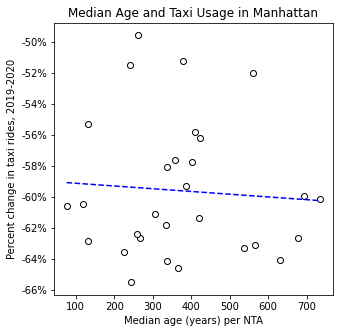

In [ ]:
plt.figure(figsize = (5,5))
plt.scatter(acs_trips['Estimate_9'], acs_trips['perc_change'], color='white', edgecolor='k')
plt.xlabel("Median age (years) per NTA")
plt.ylabel("Percent change in taxi rides, 2019-2020")
plt.title("Median Age and Taxi Usage in Manhattan")

x1 = acs_trips['Estimate_9'].min()
x2 = acs_trips['Estimate_9'].max()
y1 = ols.params[0] + (ols.params[1] * x1)
y2 = ols.params[0] + (ols.params[1] * x2)

plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.plot([x1, x2], [y1, y2], linestyle = '--', color = 'blue')

In [ ]:
acs_trips[['Estimate15', 'perc_change']].corr()

,Estimate15,perc_change
Estimate15,1.000000,0.623711
perc_change,0.623711,1.000000


In [ ]:
ols = sm.ols(formula = "perc_change ~ Estimate15", data = acs_trips).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            perc_change   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     17.19
Date:                Thu, 17 Dec 2020   Prob (F-statistic):           0.000300
Time:                        22:05:43   Log-Likelihood:                 57.156
No. Observations:                  29   AIC:                            -110.3
Df Residuals:                      27   BIC:                            -107.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.6388      0.012    -52.307      0.000      -0.664      -0.614
Estimate15  1.029e-05   2.48e-06      4.146      0.000     5.2e-06    1.54e-05
==============================================================================
Omnibus:                        3.971   Durbin-Watson:                   1.105
Prob(Omnibus):                  0.137   Jarque-Bera (JB):                2.955
Skew:                           0.780   Prob(JB):                        0.228
Kurtosis:                       3.100   Cond. No.                     9.26e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.26e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

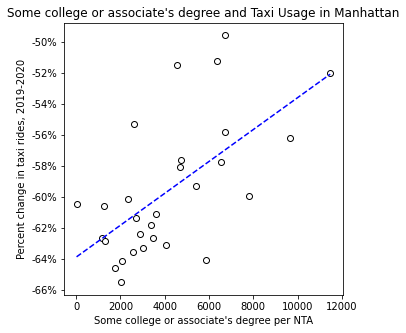

In [ ]:
plt.figure(figsize = (5,5))
plt.scatter(acs_trips['Estimate15'], acs_trips['perc_change'], color='white', edgecolor='k')
plt.xlabel("Some college or associate's degree per NTA")
plt.ylabel("Percent change in taxi rides, 2019-2020")
plt.title("Some college or associate's degree and Taxi Usage in Manhattan")

x1 = acs_trips['Estimate15'].min()
x2 = acs_trips['Estimate15'].max()
y1 = ols.params[0] + (ols.params[1] * x1)
y2 = ols.params[0] + (ols.params[1] * x2)

plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.plot([x1, x2], [y1, y2], linestyle = '--', color = 'blue')

In [ ]:
acs_trips[['Estimate16', 'perc_change']].corr()

,Estimate16,perc_change
Estimate16,1.000000,-0.227481
perc_change,-0.227481,1.000000


In [ ]:
ols = sm.ols(formula = "perc_change ~ Estimate16", data = acs_trips).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            perc_change   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     1.473
Date:                Thu, 17 Dec 2020   Prob (F-statistic):              0.235
Time:                        21:45:14   Log-Likelihood:                 50.782
No. Observations:                  29   AIC:                            -97.56
Df Residuals:                      27   BIC:                            -94.83
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.5776      0.017    -33.704      0.000      -0.613      -0.542
Estimate16 -2.017e-06   1.66e-06     -1.214      0.235   -5.43e-06    1.39e-06
==============================================================================
Omnibus:                        2.912   Durbin-Watson:                   0.433
Prob(Omnibus):                  0.233   Jarque-Bera (JB):                2.551
Skew:                           0.649   Prob(JB):                        0.279
Kurtosis:                       2.346   Cond. No.                     2.19e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.19e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

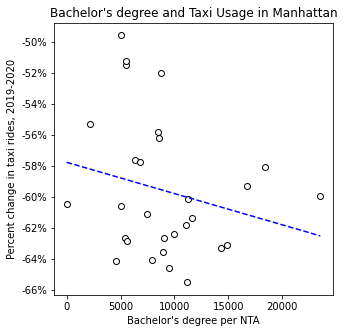

In [ ]:
plt.figure(figsize = (5,5))
plt.scatter(acs_trips['Estimate16'], acs_trips['perc_change'], color='white', edgecolor='k')
plt.xlabel("Bachelor's degree per NTA")
plt.ylabel("Percent change in taxi rides, 2019-2020")
plt.title("Bachelor's degree and Taxi Usage in Manhattan")

x1 = acs_trips['Estimate16'].min()
x2 = acs_trips['Estimate16'].max()
y1 = ols.params[0] + (ols.params[1] * x1)
y2 = ols.params[0] + (ols.params[1] * x2)

plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.plot([x1, x2], [y1, y2], linestyle = '--', color = 'blue')

In [ ]:
acs_trips[['Estimate21', 'perc_change']].corr()

,Estimate21,perc_change
Estimate21,1.000000,0.532778
perc_change,0.532778,1.000000


In [ ]:
ols = sm.ols(formula = "perc_change ~ Estimate21", data = acs_trips).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            perc_change   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.257
Method:                 Least Squares   F-statistic:                     10.70
Date:                Thu, 17 Dec 2020   Prob (F-statistic):            0.00292
Time:                        22:08:04   Log-Likelihood:                 54.853
No. Observations:                  29   AIC:                            -105.7
Df Residuals:                      27   BIC:                            -103.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.6315      0.013    -48.763      0.000      -0.658      -0.605
Estimate21   7.94e-06   2.43e-06      3.271      0.003    2.96e-06    1.29e-05
==============================================================================
Omnibus:                        2.450   Durbin-Watson:                   0.869
Prob(Omnibus):                  0.294   Jarque-Bera (JB):                2.057
Skew:                           0.634   Prob(JB):                        0.358
Kurtosis:                       2.697   Cond. No.                     9.84e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.84e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

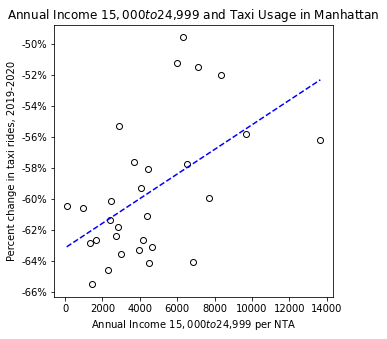

In [ ]:
plt.figure(figsize = (5,5))
plt.scatter(acs_trips['Estimate21'], acs_trips['perc_change'], color='white', edgecolor='k')
plt.xlabel("Annual Income $15,000 to $24,999 per NTA")
plt.ylabel("Percent change in taxi rides, 2019-2020")
plt.title("Annual Income $15,000 to $24,999 and Taxi Usage in Manhattan")

x1 = acs_trips['Estimate21'].min()
x2 = acs_trips['Estimate21'].max()
y1 = ols.params[0] + (ols.params[1] * x1)
y2 = ols.params[0] + (ols.params[1] * x2)

plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.plot([x1, x2], [y1, y2], linestyle = '--', color = 'blue')

In [ ]:
ols = sm.ols(formula = "perc_change ~ Estimate_2", data = acs_trips).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            perc_change   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     12.69
Date:                Thu, 17 Dec 2020   Prob (F-statistic):            0.00139
Time:                        21:45:37   Log-Likelihood:                 55.599
No. Observations:                  29   AIC:                            -107.2
Df Residuals:                      27   BIC:                            -104.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.6337      0.013    -50.199      0.000      -0.660      -0.608
Estimate_2  7.033e-06   1.97e-06      3.563      0.001    2.98e-06    1.11e-05
==============================================================================
Omnibus:                        1.632   Durbin-Watson:                   0.760
Prob(Omnibus):                  0.442   Jarque-Bera (JB):                0.964
Skew:                           0.445   Prob(JB):                        0.618
Kurtosis:                       3.067   Cond. No.                     1.18e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.18e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

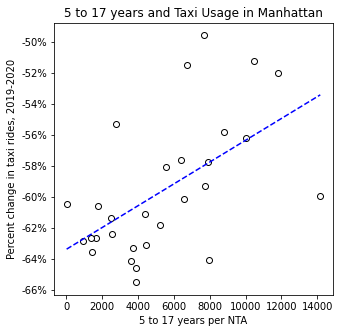

In [ ]:
plt.figure(figsize = (5,5))
plt.scatter(acs_trips['Estimate_2'], acs_trips['perc_change'], color='white', edgecolor='k')
plt.xlabel("5 to 17 years per NTA")
plt.ylabel("Percent change in taxi rides, 2019-2020")
plt.title("5 to 17 years and Taxi Usage in Manhattan")

x1 = acs_trips['Estimate_2'].min()
x2 = acs_trips['Estimate_2'].max()
y1 = ols.params[0] + (ols.params[1] * x1)
y2 = ols.params[0] + (ols.params[1] * x2)

plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.plot([x1, x2], [y1, y2], linestyle = '--', color = 'blue')

In [ ]:
ols = sm.ols(formula = "perc_change ~ Estimate17", data = acs_trips).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            perc_change   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     1.357
Date:                Thu, 17 Dec 2020   Prob (F-statistic):              0.254
Time:                        21:45:47   Log-Likelihood:                 50.723
No. Observations:                  29   AIC:                            -97.45
Df Residuals:                      27   BIC:                            -94.71
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.5832      0.014    -42.754      0.000      -0.611      -0.555
Estimate17 -1.483e-06   1.27e-06     -1.165      0.254    -4.1e-06    1.13e-06
==============================================================================
Omnibus:                        2.379   Durbin-Watson:                   0.437
Prob(Omnibus):                  0.304   Jarque-Bera (JB):                2.096
Skew:                           0.573   Prob(JB):                        0.351
Kurtosis:                       2.352   Cond. No.                     1.80e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.8e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

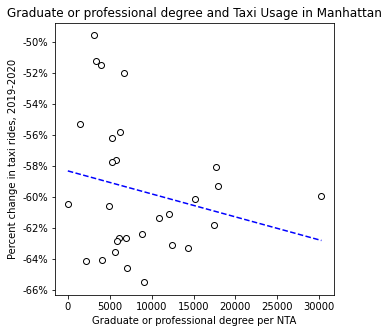

In [ ]:
plt.figure(figsize = (5,5))
plt.scatter(acs_trips['Estimate17'], acs_trips['perc_change'], color='white', edgecolor='k')
plt.xlabel("Graduate or professional degree per NTA")
plt.ylabel("Percent change in taxi rides, 2019-2020")
plt.title("Graduate or professional degree and Taxi Usage in Manhattan")

x1 = acs_trips['Estimate17'].min()
x2 = acs_trips['Estimate17'].max()
y1 = ols.params[0] + (ols.params[1] * x1)
y2 = ols.params[0] + (ols.params[1] * x2)

plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.plot([x1, x2], [y1, y2], linestyle = '--', color = 'blue')

In [ ]:
ols = sm.ols(formula = "perc_change ~ Estimate26", data = acs_trips).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            perc_change   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     4.672
Date:                Thu, 17 Dec 2020   Prob (F-statistic):             0.0397
Time:                        21:45:59   Log-Likelihood:                 52.326
No. Observations:                  29   AIC:                            -100.7
Df Residuals:                      27   BIC:                            -97.92
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.5739      0.013    -44.958      0.000      -0.600      -0.548
Estimate26 -1.442e-06   6.67e-07     -2.162      0.040   -2.81e-06   -7.32e-08
==============================================================================
Omnibus:                        2.008   Durbin-Watson:                   0.609
Prob(Omnibus):                  0.366   Jarque-Bera (JB):                1.669
Skew:                           0.447   Prob(JB):                        0.434
Kurtosis:                       2.237   Cond. No.                     3.19e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.19e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

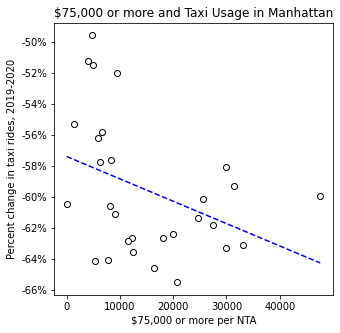

In [ ]:
plt.figure(figsize = (5,5))
plt.scatter(acs_trips['Estimate26'], acs_trips['perc_change'], color='white', edgecolor='k')
plt.xlabel("$75,000 or more per NTA")
plt.ylabel("Percent change in taxi rides, 2019-2020")
plt.title("$75,000 or more and Taxi Usage in Manhattan")

x1 = acs_trips['Estimate26'].min()
x2 = acs_trips['Estimate26'].max()
y1 = ols.params[0] + (ols.params[1] * x1)
y2 = ols.params[0] + (ols.params[1] * x2)

plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.plot([x1, x2], [y1, y2], linestyle = '--', color = 'blue')

In [ ]:
ols = sm.ols(formula = "perc_change ~ Estimate21", data = acs_trips).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            perc_change   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.257
Method:                 Least Squares   F-statistic:                     10.70
Date:                Thu, 17 Dec 2020   Prob (F-statistic):            0.00292
Time:                        21:46:09   Log-Likelihood:                 54.853
No. Observations:                  29   AIC:                            -105.7
Df Residuals:                      27   BIC:                            -103.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.6315      0.013    -48.763      0.000      -0.658      -0.605
Estimate21   7.94e-06   2.43e-06      3.271      0.003    2.96e-06    1.29e-05
==============================================================================
Omnibus:                        2.450   Durbin-Watson:                   0.869
Prob(Omnibus):                  0.294   Jarque-Bera (JB):                2.057
Skew:                           0.634   Prob(JB):                        0.358
Kurtosis:                       2.697   Cond. No.                     9.84e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.84e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

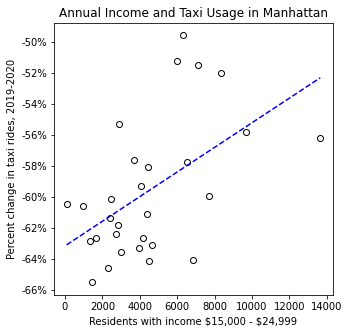

In [ ]:
plt.figure(figsize = (5,5))
plt.scatter(acs_trips['Estimate21'], acs_trips['perc_change'], color='white', edgecolor='k')
plt.xlabel("Residents with income \$15,000 - \$24,999")
plt.ylabel("Percent change in taxi rides, 2019-2020")
plt.title("Annual Income and Taxi Usage in Manhattan")

x1 = acs_trips['Estimate21'].min()
x2 = acs_trips['Estimate21'].max()
y1 = ols.params[0] + (ols.params[1] * x1)
y2 = ols.params[0] + (ols.params[1] * x2)

plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.plot([x1, x2], [y1, y2], linestyle = '--', color = 'blue')

In [ ]:
ols = sm.ols(formula = "perc_change ~ Estimate15", data = acs_trips).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            perc_change   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     17.19
Date:                Thu, 17 Dec 2020   Prob (F-statistic):           0.000300
Time:                        21:48:32   Log-Likelihood:                 57.156
No. Observations:                  29   AIC:                            -110.3
Df Residuals:                      27   BIC:                            -107.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.6388      0.012    -52.307      0.000      -0.664      -0.614
Estimate15  1.029e-05   2.48e-06      4.146      0.000     5.2e-06    1.54e-05
==============================================================================
Omnibus:                        3.971   Durbin-Watson:                   1.105
Prob(Omnibus):                  0.137   Jarque-Bera (JB):                2.955
Skew:                           0.780   Prob(JB):                        0.228
Kurtosis:                       3.100   Cond. No.                     9.26e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.26e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

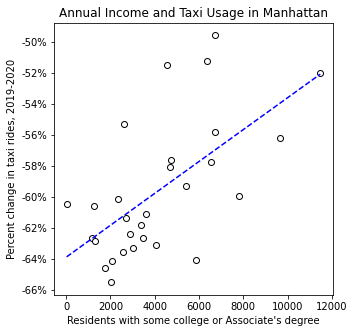

In [ ]:
plt.figure(figsize = (5,5))
plt.scatter(acs_trips['Estimate15'], acs_trips['perc_change'], color='white', edgecolor='k')
plt.xlabel("Residents with some college or Associate's degree")
plt.ylabel("Percent change in taxi rides, 2019-2020")
plt.title("Annual Income and Taxi Usage in Manhattan")

x1 = acs_trips['Estimate15'].min()
x2 = acs_trips['Estimate15'].max()
y1 = ols.params[0] + (ols.params[1] * x1)
y2 = ols.params[0] + (ols.params[1] * x2)

plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.plot([x1, x2], [y1, y2], linestyle = '--', color = 'blue')

## Maps

Mapping all of the variables of interest

(905464.739038986, 1075092.878374982, 112485.76061678902, 280480.4146430246)

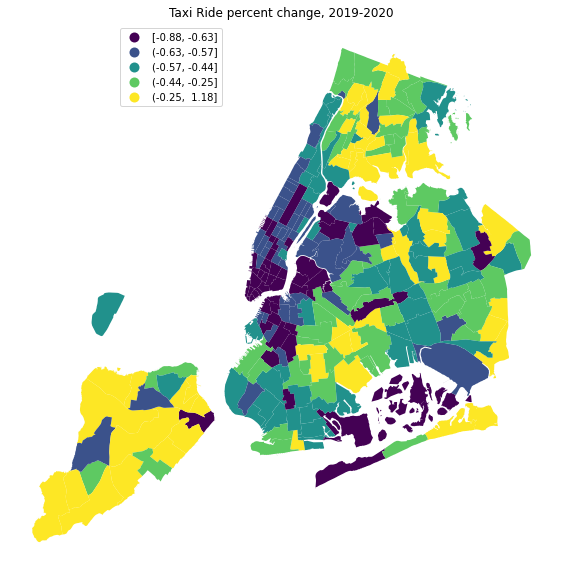

In [ ]:
plt1 = trips_byzone.plot(figsize = (10,10), column = "perc_change", scheme = "quantiles", legend = True)

leg = plt1.get_legend()
leg.set_bbox_to_anchor((0.4,1))
plt.title("Taxi Ride percent change, 2019-2020")
plt.axis(False)

(969060.880270385, 1012018.2551666418, 184509.04999694825, 263121.0425933838)

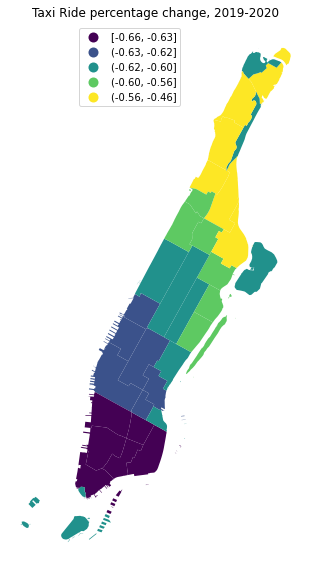

In [ ]:
plt2 = covid_trips.plot(figsize = (10,10), column = "perc_change", scheme = "quantiles", legend = True)

leg2 = plt2.get_legend()
leg2.set_bbox_to_anchor((0.6,1))
plt.title("Taxi Ride percentage change, 2019-2020")
plt.axis(False)

(969060.880270385, 1012018.2551666418, 184509.04999694825, 263121.0425933838)

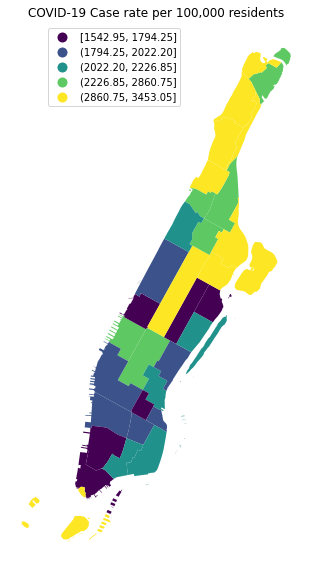

In [ ]:
plt3 = covid_bynta.plot(figsize = (10,10), column = 'CASE_RATE', scheme = 'quantiles', legend = True)

plt.title("COVID-19 Case rate per 100,000 residents")
leg3 = plt3.get_legend()
leg3.set_bbox_to_anchor((0.6,1))

plt.axis(False)

In [ ]:
acs_trips.head()

,Estimate__,Estimate_1,Estimate_2,Estimate_3,Estimate_4,Estimate_5,Estimate_6,Estimate_7,Estimate_8,Estimate_9,Estimate10,Estimate11,Estimate12,Estimate13,Estimate14,Estimate15,Estimate16,Estimate17,Estimate18,Estimate19,Estimate20,Estimate21,Estimate22,Estimate23,Estimate24,Estimate25,Estimate26,Estimate27,2010_Censu,2010_NYC_B,2010_Cen_1,PUMA,OBJECTID,BoroCode,BoroName,CountyFIPS,NTACode,NTAName,Shape__Are,Shape__Len,geometry,n_19,change,perc_change
0,52922,3258.786,7657.150,4906.304,17037.718,7191.019,5805.146,61.6,38.3,19224.542,335.1,364.9,19529.800,93.4258,67.3661,83.9274,138.1,99.0,5208.847,12.7011,9.5926,97.7,71.5,63.1,50.2,29.5,89.7,192567,427.0,7.0,209700.0,26607.0,79,1,Manhattan,061,MN01,Marble Hill-Inwood,1.773272e+07,31844.333429,"MULTIPOLYGON (((1005960.173 251370.172, 100594...",18759,-8633.0,-0.460206
1,86117,6413.088,11833.941,8279.028,29427.145,11696.000,9328.778,95.9,76.0,29808.733,738.6,861.4,32809.160,153.4880,196.3917,200.3703,327.9,260.5,10253.615,37.4708,23.3176,191.9,137.2,163.8,148.9,50.4,240.2,490461,976.0,16.0,362306.0,60848.0,74,1,Manhattan,061,MN03,Central Harlem North-Polo Grounds,2.540349e+07,27983.841731,"POLYGON ((1002388.021 243854.511, 1002358.133 ...",523255,-275831.0,-0.527145
2,52700,2692.562,6715.124,5117.492,19520.898,7696.995,5382.058,34.8,36.8,18187.822,355.0,345.0,18753.214,83.9524,71.2125,59.7530,153.9,110.1,6914.497,17.8189,10.3711,111.3,75.3,82.9,57.1,22.0,80.7,187162,427.0,7.0,161701.0,26614.0,101,1,Manhattan,061,MN04,Hamilton Heights,1.609614e+07,17411.381931,"POLYGON ((1000758.421 241841.071, 1000815.207 ...",226041,-118859.0,-0.525829
3,23673,1508.398,2745.913,3054.987,8123.563,3075.819,2455.242,24.2,24.2,7811.263,183.1,316.9,8740.718,52.0907,55.5435,97.4904,68.7,97.5,2391.894,9.3910,5.1946,56.6,41.4,33.8,129.3,10.4,27.9,80189,305.0,5.0,109509.0,19010.0,143,1,Manhattan,061,MN06,Manhattanville,1.064708e+07,17040.685896,"POLYGON ((999174.261 238490.105, 999084.570 23...",597844,-334314.0,-0.559199
4,53094,1498.935,4361.448,13561.991,16017.062,5080.501,4759.339,67.5,56.4,17009.407,448.2,551.8,18525.776,40.2594,67.3579,64.8915,259.1,422.0,19554.227,66.3080,19.0960,82.7,62.9,62.0,60.2,23.4,182.2,324817,610.0,10.0,202004.0,38020.0,144,1,Manhattan,061,MN09,Morningside Heights,2.015591e+07,20746.031807,"POLYGON ((997509.202 234911.225, 997373.694 23...",1667314,-1002740.0,-0.601410


(969060.476451303, 1012017.857675462, 184512.055028218, 263124.0642716173)

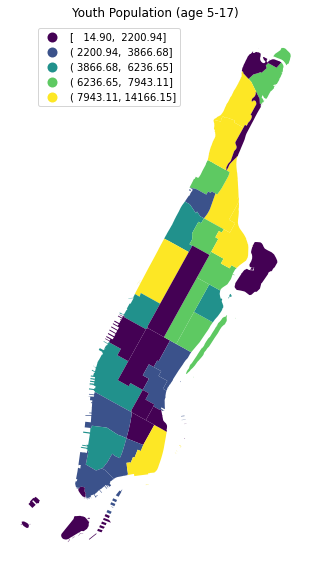

In [ ]:
plt4 = acs_trips.plot(figsize = (10,10), column = 'Estimate_2', scheme = 'quantiles', legend = True)

plt.title("Youth Population (age 5-17)")
leg4 = plt4.get_legend()
leg4.set_bbox_to_anchor((0.6,1))

plt.axis(False)

(969060.476451303, 1012017.857675462, 184512.055028218, 263124.0642716173)

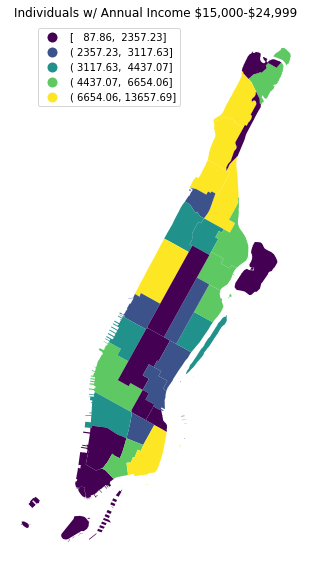

In [ ]:
plt5 = acs_trips.plot(figsize = (10,10), column = 'Estimate21', scheme = 'quantiles', legend = True)

plt.title("Individuals w/ Annual Income \$15,000-\$24,999")
leg5 = plt5.get_legend()
leg5.set_bbox_to_anchor((0.6,1))

plt.axis(False)

(969060.476451303, 1012017.857675462, 184512.055028218, 263124.0642716173)

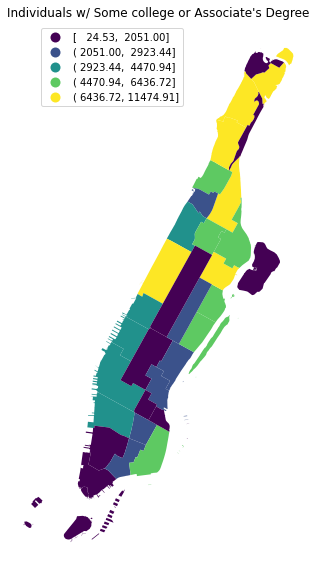

In [ ]:
plt6 = acs_trips.plot(figsize = (10,10), column = 'Estimate15', scheme = 'quantiles', legend = True)

plt.title("Individuals w/ Some college or Associate's Degree")
leg6 = plt6.get_legend()
leg6.set_bbox_to_anchor((0.6,1))

plt.axis(False)